In [22]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset with the proper delimiter
df = pd.read_csv("C:/Users/yacin/Desktop/Projet DS/Complete_Merged_Data.csv", sep=";")

# Exclure la catégorie "Coach" des données
df = df[df['position'] != 'Coach']

# Supprimer les colonnes dont le nom est 'Unnamed'
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Display shape and sample
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (15323, 53)


,full_name,age,league,position,Current Club,minutes_played_overall,nationality,appearances_overall,goals_overall,assists_overall,...,dribbles_successful_per90_percentile_overall,blocks_total_overall,ratings_total_overall,xg_per_90_overall,average_rating_percentile_overall,aerial_duels_won_total_overall,duels_per_game_overall,duels_won_percentage_overall,annual_salary_eur,annual_salary_eur_percentile
0,Aaron Cresswell,34,Premier League,Defender,West Ham United,431,England,11,0,0,...,9.0,2.0,59.98,0.00,23.0,6.0,1.89,58.82,3016000.0,52.0
1,Aaron Hickey,22,Premier League,Defender,Brentford,720,Scotland,9,0,0,...,9.0,2.0,7.32,0.00,93.0,0.0,6.00,83.33,1809600.0,29.0
2,Aaron Ramsdale,26,Premier League,Goalkeeper,Arsenal,540,England,6,0,0,...,9.0,0.0,39.22,0.00,17.0,0.0,0.17,100.00,7238400.0,83.0
3,Aaron Wan-Bissaka,26,Premier League,Defender,Manchester United,1782,England,22,0,2,...,64.0,14.0,147.98,0.01,71.0,21.0,6.62,62.59,5428800.0,73.0
4,Abdoulaye Doucouré,31,Premier League,Midfielder,Everton,2643,Mali,32,7,1,...,62.0,3.0,215.10,0.27,57.0,25.0,8.61,36.33,7841600.0,85.0


In [23]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicates
df = df.drop_duplicates()


Number of duplicate rows: 720


In [24]:
# ❓ Step 2: Handle Missing Values

# Drop columns with more than 40% missing data
threshold = 0.4 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# Fill missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            # Fill with most frequent value
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            # Convert to numeric and fill with median
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median())

# 🚨 Step 3: Remove Outliers (1st - 99th percentile)
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    upper_limit = df[col].quantile(0.99)
    lower_limit = df[col].quantile(0.01)
    df = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)]

# ✅ Final shape after cleaning
print("Cleaned dataset shape:", df.shape)

# 👀 Preview cleaned data
df.head()

Cleaned dataset shape: (9714, 53)


,full_name,age,league,position,Current Club,minutes_played_overall,nationality,appearances_overall,goals_overall,assists_overall,...,dribbles_successful_per90_percentile_overall,blocks_total_overall,ratings_total_overall,xg_per_90_overall,average_rating_percentile_overall,aerial_duels_won_total_overall,duels_per_game_overall,duels_won_percentage_overall,annual_salary_eur,annual_salary_eur_percentile
0,Aaron Cresswell,34,Premier League,Defender,West Ham United,431,England,11,0,0,...,9.0,2.0,59.980,0.00,23.0,6.0,1.890,58.82,3016000.0,52.0
5,Adam Davies,32,Premier League,Goalkeeper,Sheffield United,0,Wales,0,0,0,...,21.0,0.0,66.795,0.03,20.0,4.0,4.035,43.82,0.0,52.0
7,Adam Smith,33,Premier League,Defender,AFC Bournemouth,2158,England,28,0,2,...,21.0,11.0,188.120,0.00,32.0,19.0,5.890,49.09,0.0,5.0
8,Adam Webster,29,Premier League,Defender,Brighton & Hove Albion,1144,England,15,0,0,...,9.0,8.0,97.430,0.02,59.0,31.0,6.070,56.47,3317600.0,56.0
9,Adam Wharton,20,Premier League,Defender,Crystal Palace,1305,England,16,0,3,...,9.0,0.0,0.000,0.00,0.0,0.0,0.000,0.00,0.0,5.0


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
import pandas as pd

# Dictionnaire des features par position
position_features = {
    'goalkeeper': [
        'saves_per_game_overall', 'save_percentage_overall', 'clean_sheets_overall',
        'shots_faced_total_overall', 'conceded_overall', 'passes_completed_total_overall'
    ],
    'defender': [
        'interceptions_total_overall', 'tackles_total_overall',
        'aerial_duels_won_total_overall', 'blocks_total_overall',
        'duels_per_game_overall', 'pass_completion_rate_overall'
    ],
    'midfielder': [
        'assists_overall', 'key_passes_total_overall', 'passes_completed_total_overall',
        'dribbles_per_game_overall', 'tackles_total_overall',
        'interceptions_total_overall', 'average_rating_percentile_overall'
    ],
    'forward': [
        'goals_overall', 'xg_total_overall', 'shots_on_target_per_game_overall',
        'dribbles_per_game_overall', 'key_passes_total_overall', 'goals_involved_per_90_overall'
    ]
}

def train_predictive_fit_model(df, position_target):
    """
    Entraîne un modèle pour prédire le fit des joueurs par poste,
    avec imputation significative du salaire annual_salary_eur.
    """

    # 1. Choisir les bonnes features selon la position
    position_target = position_target.lower()
    features = position_features.get(position_target)

    if features is None:
        raise ValueError(f"Unknown position: {position_target}")

    print(f"Selected features for {position_target}: {features}")

    # 2. Nettoyer df
    df = df.copy()
    df['position'] = df['position'].astype(str).str.lower()
    df['full_name'] = df['full_name'].astype(str).str.strip()

    # 🔥 3. Imputer annual_salary_eur significativement par médiane de la position
    for pos in df['position'].unique():
        pos_filter = df['position'] == pos
        valid_salaries = df.loc[pos_filter & (df['annual_salary_eur'] > 200000), 'annual_salary_eur']
        
        if not valid_salaries.empty:
            median_salary = valid_salaries.median()
            df.loc[pos_filter & (df['annual_salary_eur'] == 0), 'annual_salary_eur'] = median_salary

    # 4. Convertir les features en numérique
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna(subset=features + ['position'])

    # 5. Créer fit_label
    df['fit_label'] = (df['position'].str.lower() == position_target).astype(int)

    # 6. Préparer X et y
    X = df[features]
    y = df['fit_label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 7. Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=42
    )

    # 8. Entraîner modèle
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    # 9. Évaluer
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_proba))

        # 10. Prédire pour tout le monde
    df['predicted_fit_score'] = model.predict_proba(X_scaled)[:, 1]
    
    # 🔥 10bis. Filtrer uniquement la vraie position cible
    df = df[df['position'] == position_target]
    
    # 11. Recommandation Top joueurs
    top_fit_players = df[['full_name', 'age', 'position', 'league', 'annual_salary_eur', 'predicted_fit_score'] + features] \
        .sort_values(by='predicted_fit_score', ascending=False).head(15)
    
    return top_fit_players



In [26]:
# Pour Goalkeepers
top_goalkeepers = train_predictive_fit_model(df, "goalkeeper")
top_goalkeepers


Selected features for goalkeeper: ['saves_per_game_overall', 'save_percentage_overall', 'clean_sheets_overall', 'shots_faced_total_overall', 'conceded_overall', 'passes_completed_total_overall']
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1765
           1       0.00      0.00      0.00       178

    accuracy                           0.91      1943
   macro avg       0.45      0.50      0.48      1943
weighted avg       0.83      0.91      0.86      1943

AUC Score: 0.7843587866441735


C:\Users\yacin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,full_name,age,position,league,annual_salary_eur,predicted_fit_score,saves_per_game_overall,save_percentage_overall,clean_sheets_overall,shots_faced_total_overall,conceded_overall,passes_completed_total_overall
2899,Ivanildo Rodrigues dos Santos,34,goalkeeper,Stars League,450000.0,0.776742,0.0,0.0,4,0.0,33,122.5
4758,Raïs M'Bolhi Ouhab,36,goalkeeper,Professional League,450000.0,0.758719,0.0,0.0,8,0.0,34,122.5
4181,Mosad Awad,29,goalkeeper,Egyptian Premier League,450000.0,0.758719,0.0,0.0,8,0.0,34,122.5
11997,Kewin Oliveira Silva,29,goalkeeper,Liga NOS,450000.0,0.720140,0.0,0.0,13,0.0,31,122.5
1552,André Campos Moreira,29,goalkeeper,Professional League,450000.0,0.700025,0.0,0.0,8,0.0,39,0.0
3436,Mailson Tenorio dos Santos,28,goalkeeper,Professional League,450000.0,0.670816,0.0,0.0,13,0.0,29,0.0
10547,Guillaume Restes,19,goalkeeper,Ligue 1,450000.0,0.632159,0.0,0.0,6,0.0,39,0.0
11912,Ignacio De Arruabarrena,27,goalkeeper,Liga NOS,450000.0,0.622006,0.0,0.0,4,0.0,41,122.5
964,Abdullah Ibrahim Al Maiouf,37,goalkeeper,Professional League,450000.0,0.611262,0.0,0.0,2,0.0,24,0.0
10351,Alaa Bellaarouch,22,goalkeeper,Ligue 1,450000.0,0.611262,0.0,0.0,2,0.0,24,0.0


In [28]:
# Pour Midfielders
top_midfielders = train_predictive_fit_model(df, "forward")
top_midfielders

Selected features for forward: ['goals_overall', 'xg_total_overall', 'shots_on_target_per_game_overall', 'dribbles_per_game_overall', 'key_passes_total_overall', 'goals_involved_per_90_overall']
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1532
           1       0.59      0.18      0.27       411

    accuracy                           0.80      1943
   macro avg       0.70      0.57      0.58      1943
weighted avg       0.77      0.80      0.76      1943

AUC Score: 0.6614804685762928


C:\Users\yacin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,full_name,age,position,league,annual_salary_eur,predicted_fit_score,goals_overall,xg_total_overall,shots_on_target_per_game_overall,dribbles_per_game_overall,key_passes_total_overall,goals_involved_per_90_overall
6999,Armindo Sieb,22,forward,Bundesliga,470000.0,0.997440,2,2.80,0.32,1.36,9.0,0.50
10921,Vítor Manuel Carvalho Oliveira,24,forward,Ligue 1,800000.0,0.994457,3,3.82,0.50,1.89,16.0,0.49
9757,Eldor Shomurodov,29,forward,Serie A,800000.0,0.991837,3,3.15,0.32,1.27,10.0,0.58
13558,Connor Metcalfe,25,forward,2. Bundesliga,800000.0,0.991544,3,4.18,0.48,1.24,23.0,0.39
13589,Dickson Abiama,26,forward,2. Bundesliga,800000.0,0.991070,3,3.56,0.35,1.69,13.0,0.47
6579,Ibrahima Niane,25,forward,Ligue 1,600000.0,0.987023,3,3.57,0.58,0.84,9.0,0.41
6703,Malick Fofana,19,forward,Ligue 1,997294.0,0.986336,3,3.61,0.55,1.86,11.0,0.53
5968,Franck William Surdez,22,forward,Pro League,800000.0,0.985868,2,3.10,0.50,1.50,15.0,0.52
7454,Theoson Siebatcheu,28,forward,Bundesliga,1248000.0,0.985698,0,1.81,0.44,0.72,14.0,0.10
6352,Ado Onaiwu,29,forward,Ligue 1,837727.0,0.985058,2,2.74,0.45,0.64,6.0,0.29


In [54]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
import pandas as pd
def train_predictive_fit_model_grid(df, position_target):
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

    df = df.copy()
    position_target = position_target.lower()
    features = position_features.get(position_target)
    if features is None:
        raise ValueError(f"Unknown position: {position_target}")

    # Nettoyage
    df['position'] = df['position'].astype(str).str.lower()
    df['full_name'] = df['full_name'].astype(str).str.strip()

    # Imputation salaire
    for pos in df['position'].unique():
        pos_filter = df['position'] == pos
        valid_salaries = df.loc[pos_filter & (df['annual_salary_eur'] > 200000), 'annual_salary_eur']
        if not valid_salaries.empty:
            median_salary = valid_salaries.median()
            df.loc[pos_filter & (df['annual_salary_eur'] == 0), 'annual_salary_eur'] = median_salary

    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna(subset=features + ['position'])

    df['fit_label'] = (df['position'] == position_target).astype(int)
    X = df[features]
    y = df['fit_label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 300, 500],
        'subsample': [0.7, 0.8, 1],
        'colsample_bytree': [0.7, 0.8, 1]
    }

    grid = GridSearchCV(
        estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    print("Best parameters:", grid.best_params_)

    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    print("🔵 XGBoost (GridSearch) Report:")
    print(classification_report(y_test, y_pred))
    print("AUC:", auc)
    print("Accuracy:", acc)

    df['predicted_fit_score'] = best_model.predict_proba(X_scaled)[:,1]
    df = df[df['position'] == position_target]

    top_players = df[['full_name', 'age', 'position', 'league', 'annual_salary_eur', 'predicted_fit_score'] + features] \
        .sort_values(by='predicted_fit_score', ascending=False).head(15)

    return top_players, auc, acc



In [32]:
# Pour Midfielders
top_midfielders = train_predictive_fit_grid_model_grid(df, "forward")
top_midfielders

Selected features for forward: ['goals_overall', 'xg_total_overall', 'shots_on_target_per_game_overall', 'dribbles_per_game_overall', 'key_passes_total_overall', 'goals_involved_per_90_overall']
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found by Grid Search: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Best AUC during search: 0.6708806602798466
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1532
           1       0.67      0.16      0.26       411

    accuracy                           0.81      1943
   macro avg       0.74      0.57      0.57      1943
weighted avg       0.78      0.81      0.75      1943

AUC Score on Test Set: 0.6834576877386238


C:\Users\yacin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,full_name,age,position,league,annual_salary_eur,predicted_fit_score,goals_overall,xg_total_overall,shots_on_target_per_game_overall,dribbles_per_game_overall,key_passes_total_overall,goals_involved_per_90_overall
12153,Ricardo Horta,30,forward,Liga NOS,800000.0,0.743001,9,0.16,0.03,0.25,2.0,0.50
2983,John Duku Antwi,30,forward,Egyptian Premier League,800000.0,0.741843,9,0.16,0.03,0.25,2.0,0.48
2570,Hassan Khalid Al Haidos,31,forward,Stars League,800000.0,0.741003,8,0.16,0.03,0.25,2.0,0.57
11695,Alejandro Marqués,24,forward,Liga NOS,800000.0,0.738943,9,0.16,0.03,0.25,2.0,0.66
11941,João Diogo Alves Rodrigues,26,forward,Liga NOS,800000.0,0.737497,8,0.16,0.03,0.25,2.0,0.52
4807,Rida Bensayah,29,forward,Ligue 1,800000.0,0.736454,8,0.16,0.03,0.25,2.0,0.68
3648,Mitchell te Vrede,31,forward,Professional League,800000.0,0.735248,12,0.16,0.03,0.25,2.0,0.57
11780,Clayton,25,forward,Liga NOS,800000.0,0.734934,8,0.16,0.03,0.25,2.0,0.48
11707,Álvaro Djaló,25,forward,Liga NOS,800000.0,0.734778,8,0.16,0.03,0.25,2.0,0.65
11961,João Silva,25,forward,Liga NOS,800000.0,0.734570,11,0.16,0.03,0.25,2.0,0.52


In [33]:
# Pour Goalkeepers
top_goalkeepers = train_predictive_fit_grid_model_grid(df, "goalkeeper")
top_goalkeepers

Selected features for goalkeeper: ['saves_per_game_overall', 'save_percentage_overall', 'clean_sheets_overall', 'shots_faced_total_overall', 'conceded_overall', 'passes_completed_total_overall']
Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\yacin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found by Grid Search: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
Best AUC during search: 0.8201957033808135
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1765
           1       0.00      0.00      0.00       178

    accuracy                           0.91      1943
   macro avg       0.45      0.50      0.48      1943
weighted avg       0.83      0.91      0.86      1943

AUC Score on Test Set: 0.7970859725626253


C:\Users\yacin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yacin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yacin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,full_name,age,position,league,annual_salary_eur,predicted_fit_score,saves_per_game_overall,save_percentage_overall,clean_sheets_overall,shots_faced_total_overall,conceded_overall,passes_completed_total_overall
5,Adam Davies,32,goalkeeper,Premier League,450000.0,0.288695,0.0,0.0,0,0.0,0,122.5
8722,Roy Kortsmit,32,goalkeeper,Eredivisie,450000.0,0.288695,0.0,0.0,0,0.0,0,122.5
8580,Mark Spenkelink,28,goalkeeper,Eredivisie,450000.0,0.288695,0.0,0.0,0,0.0,0,122.5
8625,Mikki Avelon Leander van Sas,21,goalkeeper,Eredivisie,450000.0,0.288695,0.0,0.0,0,0.0,0,122.5
8639,Nando Verdoni,20,goalkeeper,Eredivisie,450000.0,0.288695,0.0,0.0,0,0.0,0,122.5
8647,Niek Schiks,21,goalkeeper,Eredivisie,450000.0,0.288695,0.0,0.0,0,0.0,0,122.5
8648,Niels Martens,20,goalkeeper,Eredivisie,450000.0,0.288695,0.0,0.0,0,0.0,0,122.5
8676,Paul Peters Reverson,19,goalkeeper,Eredivisie,450000.0,0.288695,0.0,0.0,0,0.0,0,122.5
8683,Plamen Andreev,20,goalkeeper,Eredivisie,450000.0,0.288695,0.0,0.0,0,0.0,0,122.5
8691,Ramazan Bayram,20,goalkeeper,Eredivisie,450000.0,0.288695,0.0,0.0,0,0.0,0,122.5


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import pandas as pd
from sklearn.metrics import accuracy_score

# Dictionnaire des features par position
position_features = {
    'goalkeeper': [
        'saves_per_game_overall', 'save_percentage_overall', 'clean_sheets_overall',
        'shots_faced_total_overall', 'conceded_overall', 'passes_completed_total_overall'
    ],
    'defender': [
        'interceptions_total_overall', 'tackles_total_overall',
        'aerial_duels_won_total_overall', 'blocks_total_overall',
        'duels_per_game_overall', 'pass_completion_rate_overall'
    ],
    'midfielder': [
        'assists_overall', 'key_passes_total_overall', 'passes_completed_total_overall',
        'dribbles_per_game_overall', 'tackles_total_overall',
        'interceptions_total_overall', 'average_rating_percentile_overall'
    ],
    'forward': [
        'goals_overall', 'xg_total_overall', 'shots_on_target_per_game_overall',
        'dribbles_per_game_overall', 'key_passes_total_overall', 'goals_involved_per_90_overall'
    ]
}

def train_lightgbm_fit_model(df, position_target):
    from lightgbm import LGBMClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

    df = df.copy()
    position_target = position_target.lower()
    features = position_features.get(position_target)
    if features is None:
        raise ValueError(f"Unknown position: {position_target}")

    # Nettoyage
    df['position'] = df['position'].astype(str).str.lower()
    df['full_name'] = df['full_name'].astype(str).str.strip()

    # Imputation salaire
    for pos in df['position'].unique():
        pos_filter = df['position'] == pos
        valid_salaries = df.loc[pos_filter & (df['annual_salary_eur'] > 200000), 'annual_salary_eur']
        if not valid_salaries.empty:
            median_salary = valid_salaries.median()
            df.loc[pos_filter & (df['annual_salary_eur'] == 0), 'annual_salary_eur'] = median_salary

    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna(subset=features + ['position'])

    df['fit_label'] = (df['position'] == position_target).astype(int)
    X = df[features]
    y = df['fit_label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

    model = LGBMClassifier(class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    print("🟢 LightGBM Report:")
    print(classification_report(y_test, y_pred))
    print("AUC:", auc)
    print("Accuracy:", acc)

    df['predicted_fit_score'] = model.predict_proba(X_scaled)[:,1]
    df = df[df['position'] == position_target]

    top_players = df[['full_name', 'age', 'position', 'league', 'annual_salary_eur', 'predicted_fit_score'] + features] \
        .sort_values(by='predicted_fit_score', ascending=False).head(15)

    return top_players, auc, acc
def train_catboost_fit_model(df, position_target):
    from catboost import CatBoostClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

    df = df.copy()
    position_target = position_target.lower()
    features = position_features.get(position_target)
    if features is None:
        raise ValueError(f"Unknown position: {position_target}")

    # Nettoyage
    df['position'] = df['position'].astype(str).str.lower()
    df['full_name'] = df['full_name'].astype(str).str.strip()

    # Imputation salaire
    for pos in df['position'].unique():
        pos_filter = df['position'] == pos
        valid_salaries = df.loc[pos_filter & (df['annual_salary_eur'] > 200000), 'annual_salary_eur']
        if not valid_salaries.empty:
            median_salary = valid_salaries.median()
            df.loc[pos_filter & (df['annual_salary_eur'] == 0), 'annual_salary_eur'] = median_salary

    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna(subset=features + ['position'])

    df['fit_label'] = (df['position'] == position_target).astype(int)
    X = df[features]
    y = df['fit_label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

    model = CatBoostClassifier(verbose=0, random_state=42, class_weights=[1, (len(y_train)-y_train.sum())/y_train.sum()])
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    print("🟣 CatBoost Report:")
    print(classification_report(y_test, y_pred))
    print("AUC:", auc)
    print("Accuracy:", acc)

    df['predicted_fit_score'] = model.predict_proba(X_scaled)[:,1]
    df = df[df['position'] == position_target]

    top_players = df[['full_name', 'age', 'position', 'league', 'annual_salary_eur', 'predicted_fit_score'] + features] \
        .sort_values(by='predicted_fit_score', ascending=False).head(15)

    return top_players, auc, acc




In [37]:
train_lightgbm_fit_model(df, "forward")

[LightGBM] [Info] Number of positive: 1646, number of negative: 6125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 7771, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
🟢 LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1532
           1       0.43      0.38      0.41       411

    accuracy                           0.76      1943
   macro avg       0.63      0.62      0.63      1943
weighted avg       0.75      0.76      0.76      1943

AUC Score: 0.6703218603291978


,full_name,age,position,league,annual_salary_eur,predicted_fit_score,goals_overall,xg_total_overall,shots_on_target_per_game_overall,dribbles_per_game_overall,key_passes_total_overall,goals_involved_per_90_overall
10921,Vítor Manuel Carvalho Oliveira,24,forward,Ligue 1,800000.0,0.991730,3,3.82,0.50,1.89,16.0,0.49
9786,Federico Bonazzoli,27,forward,Serie A,2220000.0,0.989376,3,3.91,0.54,0.46,8.0,0.36
6579,Ibrahima Niane,25,forward,Ligue 1,600000.0,0.988560,3,3.57,0.58,0.84,9.0,0.41
6999,Armindo Sieb,22,forward,Bundesliga,470000.0,0.985723,2,2.80,0.32,1.36,9.0,0.50
9511,Sheraldo Becker,29,forward,La Liga,800000.0,0.981503,2,2.90,0.67,0.47,8.0,0.47
9469,Roger Martí,33,forward,La Liga,1080000.0,0.980488,2,3.72,0.52,0.48,12.0,0.33
7175,Johannes Eggestein,26,forward,Bundesliga,840000.0,0.978579,3,3.94,0.59,0.77,24.0,0.35
6703,Malick Fofana,19,forward,Ligue 1,997294.0,0.977359,3,3.61,0.55,1.86,11.0,0.53
10195,Riccardo Sottil,25,forward,Serie A,1110000.0,0.976766,2,3.58,0.59,1.77,13.0,0.41
13589,Dickson Abiama,26,forward,2. Bundesliga,800000.0,0.976698,3,3.56,0.35,1.69,13.0,0.47


In [38]:
train_catboost_fit_model(df, "forward")

🟣 CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1532
           1       0.45      0.40      0.43       411

    accuracy                           0.77      1943
   macro avg       0.65      0.64      0.64      1943
weighted avg       0.76      0.77      0.76      1943

AUC Score: 0.68109368349501


,full_name,age,position,league,annual_salary_eur,predicted_fit_score,goals_overall,xg_total_overall,shots_on_target_per_game_overall,dribbles_per_game_overall,key_passes_total_overall,goals_involved_per_90_overall
8369,Dylan Vente,25,forward,Eredivisie,800000.0,0.978076,11,0.00,0.00,0.00,0.0,0.49
3017,João Pedro Pereira dos Santos,31,forward,Professional League,800000.0,0.977524,11,0.00,0.00,0.00,0.0,0.51
2012,Cristian Tello,33,forward,Professional League,800000.0,0.977524,11,0.00,0.00,0.00,0.0,0.51
8319,Chuba Akpom,29,forward,Eredivisie,1660000.0,0.977370,3,3.45,0.62,1.38,5.0,0.43
12794,Sambou Soumano,23,forward,Ligue 2,800000.0,0.977053,12,0.00,0.00,0.00,0.0,0.47
3099,Karl Toko Ekambi,32,forward,Professional League,800000.0,0.976325,11,0.00,0.00,0.00,0.0,0.43
4209,Mostafa Mohamed,24,forward,Egyptian Premier League,800000.0,0.974224,11,0.16,0.03,0.25,2.0,0.50
9786,Federico Bonazzoli,27,forward,Serie A,2220000.0,0.973628,3,3.91,0.54,0.46,8.0,0.36
11961,João Silva,25,forward,Liga NOS,800000.0,0.973581,11,0.16,0.03,0.25,2.0,0.52
14252,Isac Lidberg,26,forward,Eredivisie,490000.0,0.970558,4,4.10,0.50,0.45,10.0,0.67


In [39]:
train_catboost_fit_model(df, "goalkeeper")

🟣 CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84      1765
           1       0.22      0.70      0.33       178

    accuracy                           0.74      1943
   macro avg       0.59      0.72      0.59      1943
weighted avg       0.89      0.74      0.79      1943

AUC Score: 0.7887035681319031


,full_name,age,position,league,annual_salary_eur,predicted_fit_score,saves_per_game_overall,save_percentage_overall,clean_sheets_overall,shots_faced_total_overall,conceded_overall,passes_completed_total_overall
12934,Andreas Luthe,37,goalkeeper,Bundesliga,450000.0,0.992025,1.0,20.0,0,5.0,4,22.0
6537,Gauthier Gallon,31,goalkeeper,Ligue 1,632400.0,0.991563,0.0,0.0,0,2.0,0,12.0
3436,Mailson Tenorio dos Santos,28,goalkeeper,Professional League,450000.0,0.958942,0.0,0.0,13,0.0,29,0.0
9043,Daniel Cárdenas,27,goalkeeper,La Liga,450000.0,0.953319,0.0,0.0,0,1.0,1,21.0
11997,Kewin Oliveira Silva,29,goalkeeper,Liga NOS,450000.0,0.929310,0.0,0.0,13,0.0,31,122.5
2914,Jacob Rinne,31,goalkeeper,Professional League,450000.0,0.919315,0.0,0.0,1,0.0,48,0.0
12053,Matheus Lima Magalhães,32,goalkeeper,Liga NOS,450000.0,0.909472,0.0,0.0,6,0.0,47,122.5
11912,Ignacio De Arruabarrena,27,goalkeeper,Liga NOS,450000.0,0.889210,0.0,0.0,4,0.0,41,122.5
5597,Yazan Naim Hussein,25,goalkeeper,Stars League,450000.0,0.878979,0.0,0.0,0,0.0,24,122.5
11729,Andrew da Silva Ventura,23,goalkeeper,Liga NOS,450000.0,0.875597,0.0,0.0,9,0.0,42,122.5


In [41]:
train_lightgbm_fit_model(df, "goalkeeper")

[LightGBM] [Info] Number of positive: 710, number of negative: 7061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 7771, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
🟢 LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84      1765
           1       0.22      0.68      0.33       178

    accuracy                           0.75      1943
   macro avg       0.59      0.72      0.59      1943
weighted avg       0.89      0.75      0.80      1943

AUC Score: 0.787600662061941


,full_name,age,position,league,annual_salary_eur,predicted_fit_score,saves_per_game_overall,save_percentage_overall,clean_sheets_overall,shots_faced_total_overall,conceded_overall,passes_completed_total_overall
2899,Ivanildo Rodrigues dos Santos,34,goalkeeper,Stars League,450000.0,0.941623,0.0,0.0,4,0.0,33,122.5
11997,Kewin Oliveira Silva,29,goalkeeper,Liga NOS,450000.0,0.932677,0.0,0.0,13,0.0,31,122.5
3436,Mailson Tenorio dos Santos,28,goalkeeper,Professional League,450000.0,0.932448,0.0,0.0,13,0.0,29,0.0
4181,Mosad Awad,29,goalkeeper,Egyptian Premier League,450000.0,0.923204,0.0,0.0,8,0.0,34,122.5
4758,Raïs M'Bolhi Ouhab,36,goalkeeper,Professional League,450000.0,0.923204,0.0,0.0,8,0.0,34,122.5
10351,Alaa Bellaarouch,22,goalkeeper,Ligue 1,450000.0,0.907229,0.0,0.0,2,0.0,24,0.0
964,Abdullah Ibrahim Al Maiouf,37,goalkeeper,Professional League,450000.0,0.907229,0.0,0.0,2,0.0,24,0.0
4640,Paulo Victor de Mileo Vidotti,37,goalkeeper,Professional League,450000.0,0.878771,0.0,0.0,12,0.0,29,0.0
2695,Houssine Chadli,31,goalkeeper,Botola Pro,450000.0,0.847752,0.0,0.0,3,0.0,32,122.5
12151,Ricardo Batista,38,goalkeeper,Liga NOS,450000.0,0.845278,0.0,0.0,10,0.0,41,122.5


In [50]:
import pandas as pd

def create_comparison_table(results_dict):
    """
    Crée un DataFrame Pandas comparatif des AUC et Accuracy pour plusieurs modèles.
    
    Args:
        results_dict (dict): {nom_modèle: (auc_score, accuracy_score)}
        
    Returns:
        pd.DataFrame
    """
    data = {
        'Model': [],
        'AUC Score': [],
        'Accuracy Score': []
    }

    for model_name, (auc, acc) in results_dict.items():
        data['Model'].append(model_name)
        data['AUC Score'].append(round(auc, 4))
        data['Accuracy Score'].append(round(acc, 4))

    df_results = pd.DataFrame(data)
    return df_results.sort_values(by='AUC Score', ascending=False).reset_index(drop=True)


In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(results_dict):
    """
    Crée un bar plot comparatif entre AUC et Accuracy pour plusieurs modèles.
    
    Args:
        results_dict (dict): {nom_modèle: (auc_score, accuracy_score)}
    """
    models = list(results_dict.keys())
    auc_scores = [results_dict[m][0] for m in models]
    acc_scores = [results_dict[m][1] for m in models]

    x = np.arange(len(models))  # positions
    width = 0.35  # largeur des barres

    fig, ax = plt.subplots(figsize=(10,6))

    rects1 = ax.bar(x - width/2, auc_scores, width, label='AUC Score', color='blue')
    rects2 = ax.bar(x + width/2, acc_scores, width, label='Accuracy Score', color='green')

    # Annoter les barres
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_ylabel('Score')
    ax.set_title('Comparison of AUC and Accuracy by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()


Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\yacin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
🔵 XGBoost (GridSearch) Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1765
           1       0.00      0.00      0.00       178

    accuracy                           0.91      1943
   macro avg       0.45      0.50      0.48      1943
weighted avg       0.83      0.91      0.86      1943

AUC: 0.7970859725626253
Accuracy: 0.9083890890375708
[LightGBM] [Info] Number of positive: 710, number of negative: 7061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 7771, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training fro

C:\Users\yacin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yacin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yacin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🟣 CatBoost Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84      1765
           1       0.22      0.70      0.33       178

    accuracy                           0.74      1943
   macro avg       0.59      0.72      0.59      1943
weighted avg       0.89      0.74      0.79      1943

AUC: 0.7887035681319031
Accuracy: 0.7416366443643849


,Model,AUC Score,Accuracy Score
0,XGBoost (Grid),0.7971,0.9084
1,CatBoost,0.7887,0.7416
2,LightGBM,0.7876,0.7452


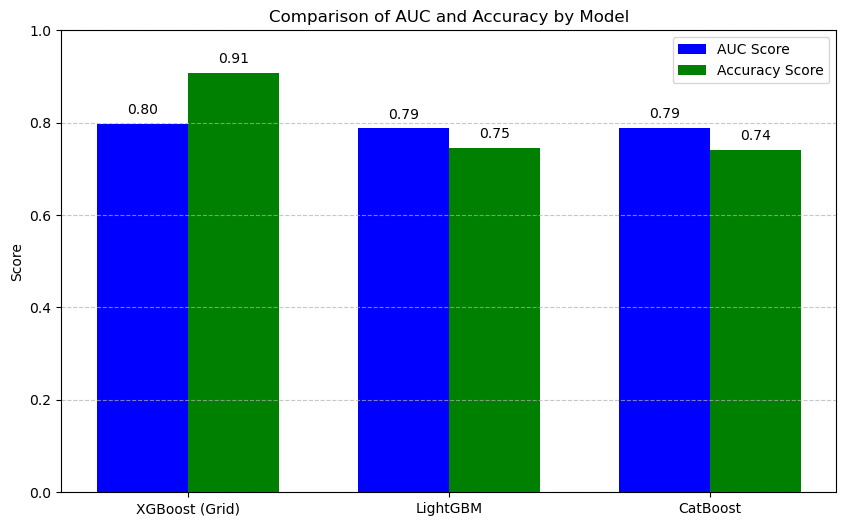

In [57]:
# Après avoir utilisé les 3 fonctions
_, auc_xgb, acc_xgb = train_predictive_fit_model_grid(df, "goalkeeper")
_, auc_lgbm, acc_lgbm = train_lightgbm_fit_model(df, "goalkeeper")
_, auc_cat, acc_cat = train_catboost_fit_model(df, "goalkeeper")

# Rassembler tous les résultats
results = {
    'XGBoost (Grid)': (auc_xgb, acc_xgb),
    'LightGBM': (auc_lgbm, acc_lgbm),
    'CatBoost': (auc_cat, acc_cat)
}
comparison_table = create_comparison_table(results)
display(comparison_table)
plot_model_comparison(results)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\yacin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
🔵 XGBoost (GridSearch) Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1532
           1       0.67      0.16      0.26       411

    accuracy                           0.81      1943
   macro avg       0.74      0.57      0.57      1943
weighted avg       0.78      0.81      0.75      1943

AUC: 0.6834576877386238
Accuracy: 0.8054554812146165
[LightGBM] [Info] Number of positive: 1646, number of negative: 6125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 7771, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training fro

,Model,AUC Score,Accuracy Score
0,XGBoost (Grid),0.6835,0.8055
1,CatBoost,0.6811,0.7689
2,LightGBM,0.6703,0.7617


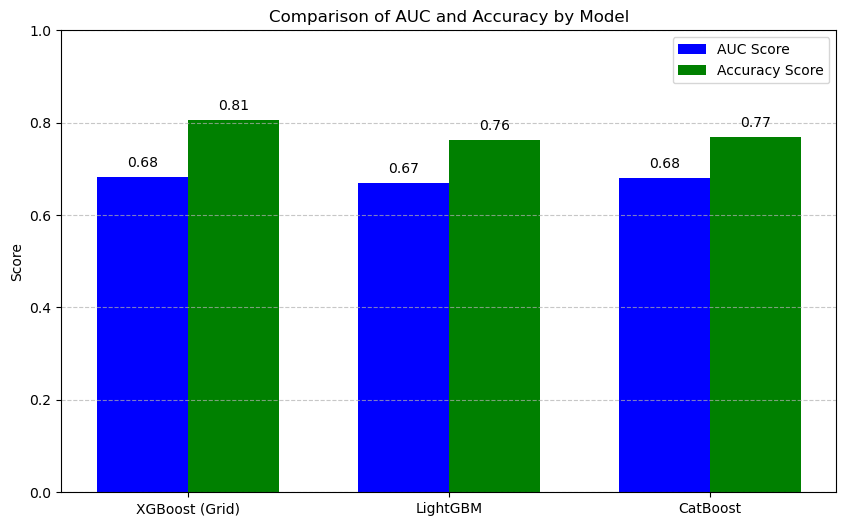

In [58]:
# Après avoir utilisé les 3 fonctions
_, auc_xgb, acc_xgb = train_predictive_fit_model_grid(df, "forward")
_, auc_lgbm, acc_lgbm = train_lightgbm_fit_model(df, "forward")
_, auc_cat, acc_cat = train_catboost_fit_model(df, "forward")

# Rassembler tous les résultats
results = {
    'XGBoost (Grid)': (auc_xgb, acc_xgb),
    'LightGBM': (auc_lgbm, acc_lgbm),
    'CatBoost': (auc_cat, acc_cat)
}
comparison_table = create_comparison_table(results)
display(comparison_table)
plot_model_comparison(results)
